In [2]:
# pip install opencv-python

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [16]:
def extract_orb_features(image_path):
    """
    Extracts ORB features from an image.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")
    # Initialize the ORB detector
    orb = cv2.ORB_create()
    # Find the keypoints and descriptors with ORB
    kp, des = orb.detectAndCompute(img, None)
    return kp, des

def visualize_keypoints(image_path):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("The image path is invalid.")

    # Initialize the AKAZE detector
    ORB = cv2.ORB_create()

    # Detect keypoints and descriptors with AKAZE
    kp, des = ORB.detectAndCompute(img, None)
    kp = kp[:100]
    len(kp)
    # Draw keypoints on the image
    img_with_keypoints = cv2.drawKeypoints(img, kp, None, color=(255, 0, 0), flags=cv2.DrawMatchesFlags_DEFAULT)

    # Display the image with keypoints
    plt.imshow(img_with_keypoints, cmap='gray')
    plt.title(f'Image: {image_name(image_path)} Keypoints')
    plt.axis('off')
    plt.show()

def image_name(image_path):
    return os.path.splitext(os.path.basename(image_path))[0]


image1_path = 'nk_collection_meubels_cleaned/meubel_1.jpg'
image2_path = 'nk_collection_meubels_cleaned/meubel_2.jpg'

import pandas as pd

def get_table(sims):
    """
    This function takes the output produced by either the compute_similarities \ 
    or compute_similarities_testsets function, and returns a pandas dataframe/table \
    and also saves it in excel.
    """
    
    data = {}
    rows = []

    for key, value in sims.items():
        if key[0] not in data:
            data[key[0]] = []
        if key[1] not in rows:
            rows.append(key[1])
        data[key[0]].append(value)
        
    data = {key[:key.rfind(".")]:value for key, value in data.items()}
    rows = [row[:row.rfind(".")] for row in rows]
        
    df = pd.DataFrame(data, index=rows)
    #df.to_excel('output.xlsx')
    return df.T
    


<>:46: SyntaxWarning: invalid escape sequence '\ '
<>:46: SyntaxWarning: invalid escape sequence '\ '
C:\Users\used\AppData\Local\Temp\ipykernel_2860\4278976470.py:46: SyntaxWarning: invalid escape sequence '\ '
  """


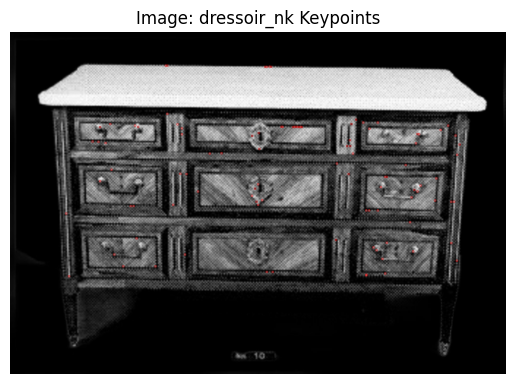

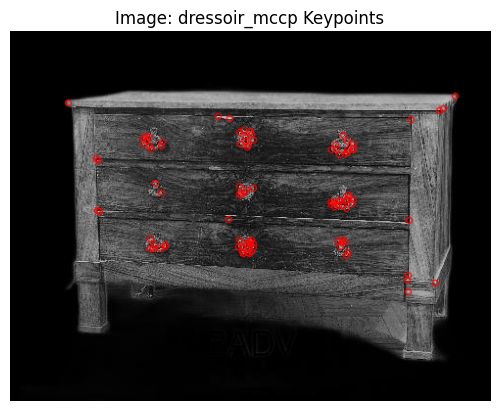

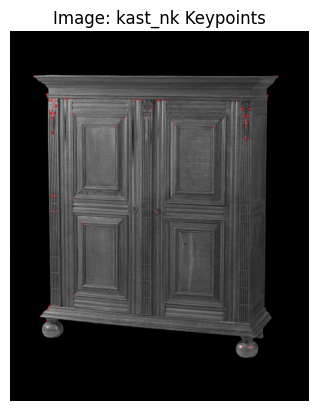

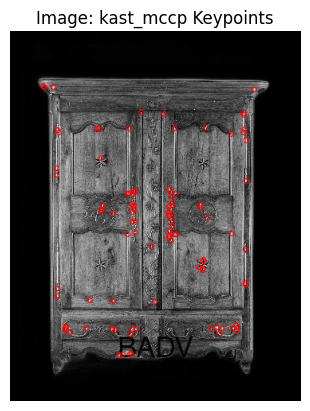

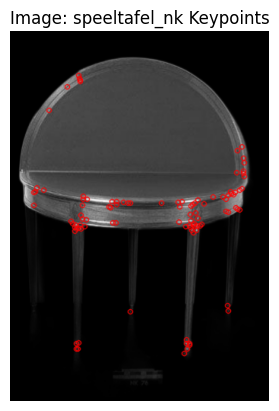

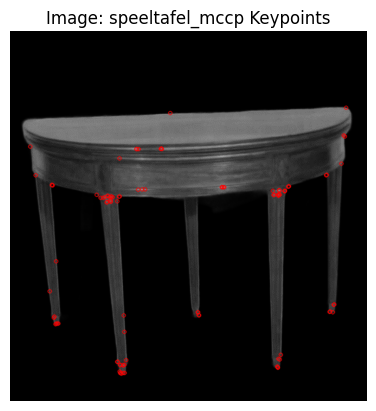

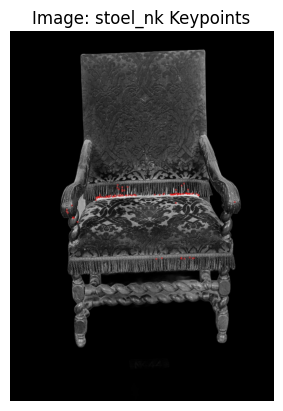

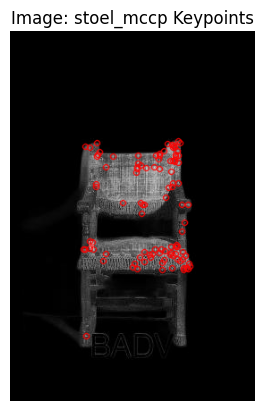

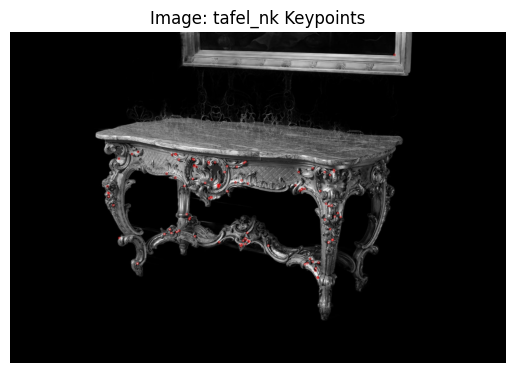

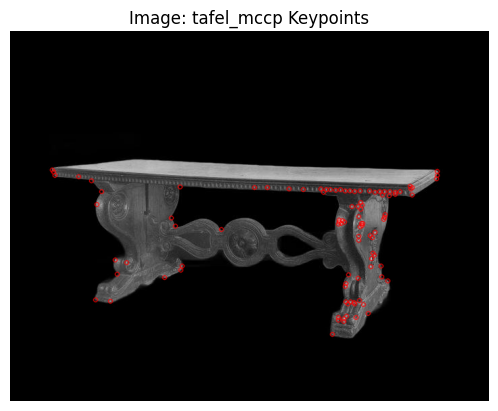

In [18]:
nk_index = 0
munich_index = 0
nk_path = "nk_testset_no_back"
munich_path = "munich_testset_no_back"
nk_testset = os.listdir(nk_path)
munich_testset = os.listdir(munich_path)


while nk_index < len(nk_testset) and munich_index < len(munich_testset):
    # Print from nk_testset
    nk_img = nk_testset[nk_index]
    nk_img_path = os.path.join(nk_path, nk_img)
    visualize_keypoints(nk_img_path)
    nk_index += 1
    
    # Check if we can print from munich_testset
    if munich_index < len(munich_testset):
        munich_img = munich_testset[munich_index]
        munich_img_path = os.path.join(munich_path, munich_img)
        visualize_keypoints(munich_img_path)
        munich_index += 1


# Example usage:
nk_path = "nk_testset"
munich_path = "munich_testset"

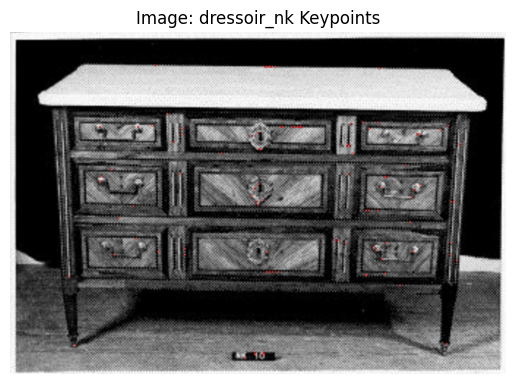

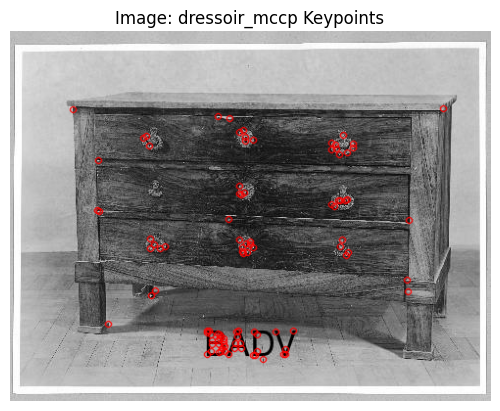

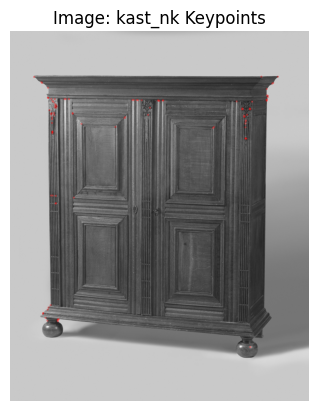

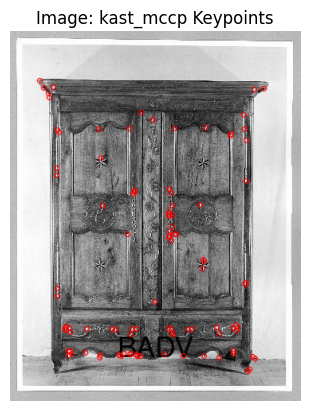

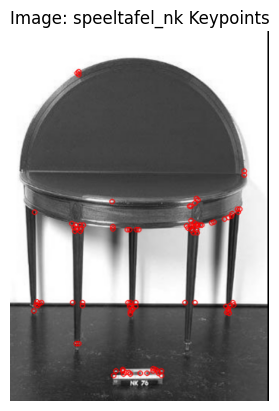

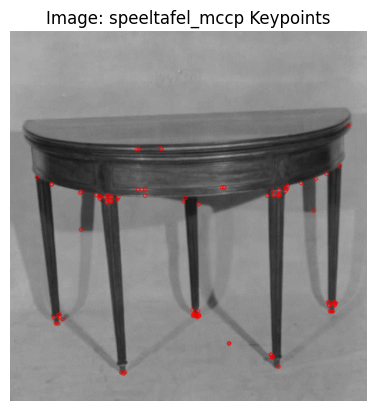

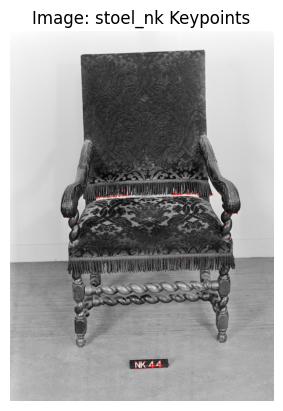

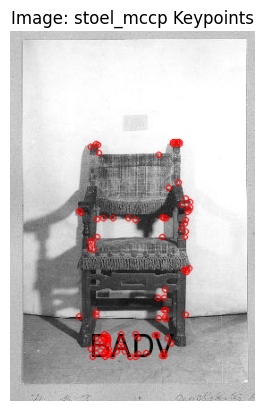

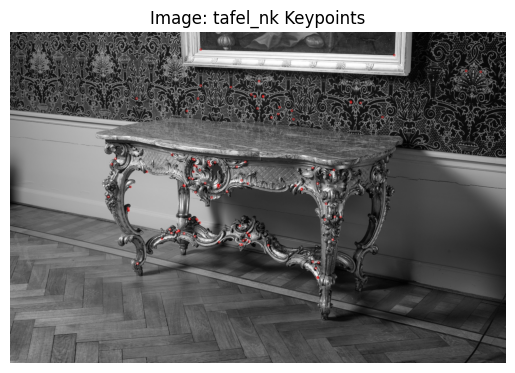

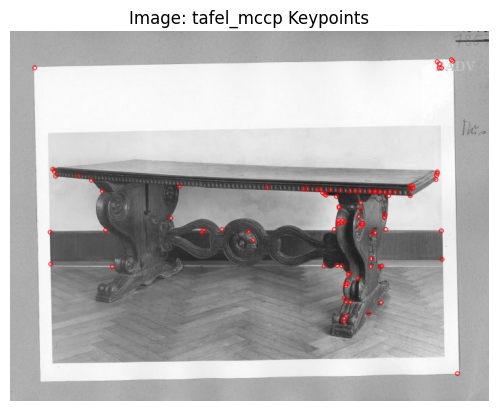

In [19]:
nk_index = 0
munich_index = 0
nk_path = "nk_testset"
munich_path = "munich_testset"
nk_testset = os.listdir(nk_path)
munich_testset = os.listdir(munich_path)


while nk_index < len(nk_testset) and munich_index < len(munich_testset):
    # Print from nk_testset
    nk_img = nk_testset[nk_index]
    nk_img_path = os.path.join(nk_path, nk_img)
    visualize_keypoints(nk_img_path)
    nk_index += 1
    
    # Check if we can print from munich_testset
    if munich_index < len(munich_testset):
        munich_img = munich_testset[munich_index]
        munich_img_path = os.path.join(munich_path, munich_img)
        visualize_keypoints(munich_img_path)
        munich_index += 1


# Example usage:
nk_path = "nk_testset"
munich_path = "munich_testset"

In [15]:
def compute_orb_similarity(des1, des2, kp1, kp2):
    """
    Computes similarity between two sets of ORB descriptors using BFMatcher and ratio test.
    """
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    # Match descriptors with KNN
    matches = bf.knnMatch(des1, des2, k=2)
    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.90 * n.distance:
            good_matches.append(m)

    if len(good_matches) < 10:
        return 0.0  # Not enough matches to compute homography

    # Apply RANSAC to find the best transformation
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Use RANSAC to find the best transformation matrix
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    if mask is None:
        return 0.0  # If RANSAC fails to find a valid transformation

    # Calculate the number of inliers
    num_inliers = np.sum(mask)

    # Compute the similarity score based on the number of inliers
    similarity_score = num_inliers / len(good_matches)
    return similarity_score

def compute_similarities_testsets(munich_testset, nk_testset, 
                                  munich_path="munich_testset", 
                                  nk_path="nk_testset"):
    """
    This function takes four arguments: 
    - munich_testset, which contains grayscaled images from the Munich database.
    - nk_testset, which contains grayscaled images from the NK collection API.
    - munich path, the path to the directory of the Munich images. 
    - nk_path, the path to the directory of the NK images. 
    
    It then computes the ORB descriptors for the Munich images and all the
    NK collection images. Afterwards, it computes the similarity using ORB features.
    It then saves the similarity and the two images as key-value pairs in a dictionary.
    """
    
    similarities = {}
    for nk_img in nk_testset:
        nk_img_path = os.path.join(nk_path, nk_img)
        try:
            nk_kp, nk_des = extract_orb_features(nk_img_path)
        except ValueError as e:
            print(e)
            continue
        for munich_img in munich_testset:
            munich_img_path = os.path.join(munich_path, munich_img)
            try:
                munich_kp, munich_des = extract_orb_features(munich_img_path)
            except ValueError as e:
                print(e)
                continue
            similarity = compute_orb_similarity(nk_des, munich_des, nk_kp, munich_kp)
            similarities[(nk_img, munich_img)] = similarity
        
    return similarities

# Example usage:
nk_path = "nk_testset_no_back"
munich_path = "munich_testset_no_back"

if not os.path.exists(nk_path):
    raise FileNotFoundError(f"The path {nk_path} does not exist.")
if not os.path.exists(munich_path):
    raise FileNotFoundError(f"The path {munich_path} does not exist.")

nk_testset = os.listdir(nk_path)
munich_testset = os.listdir(munich_path)

sims = compute_similarities_testsets(munich_testset, nk_testset, munich_path, nk_path)
get_table(sims)


,dressoir_mccp,kast_mccp,speeltafel_mccp,stoel_mccp,tafel_mccp
dressoir_nk,0.102273,0.186047,0.191176,0.115385,0.140625
kast_nk,0.247423,0.500000,0.195876,0.211111,0.205882
speeltafel_nk,0.216867,0.253012,0.228571,0.170732,0.312500
stoel_nk,0.123288,0.152778,0.166667,0.235294,0.283582
tafel_nk,0.142857,0.289474,0.195122,0.164179,0.160000


In [142]:
import cv2
import os
import numpy as np

def compute_similarity(image1_path, image2_path):
    np.random.seed(42)
    # Load the images in grayscale
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    if img1 is None or img2 is None:
        raise ValueError("One or both of the image paths are invalid.")

    # Initialize the ORB detector
    orb = cv2.ORB_create()

    # Find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Use BFMatcher with default params
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Match descriptors
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    # print(matches[10:])
    # Apply RANSAC to find the best transformation
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # # Use RANSAC to find the best transformation matrix
    # M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 50,maxIters=10000)

    # # Calculate the number of inliers
    # num_inliers = np.sum(mask)

    # # Compute the similarity score based on the number of inliers
    # similarity_score = num_inliers / 100
    # return similarity_score
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 15)
    matches_mask = mask.ravel().tolist()

    num_inliers = np.sum(matches_mask)
    num_matches = len(matches)
    
    similarity_percentage = (num_inliers / num_matches) * 100
    return similarity_percentage

def compute_similarities_testsets(munich_testset, nk_testset, 
                                  munich_path="munich_testset", 
                                  nk_path="nk_testset"):
    """
    This function takes four arguments: 
    - munich_testset, which contains grayscaled images from the Munich database.
    - nk_testset, which contains grayscaled images from the NK collection API.
    - munich path, the path to the directory of the Munich images. 
    - nk_path, the path to the directory of the NK images. 
    
    It then computes the similarity using ORB features.
    It then saves the similarity and the two images as key-value pairs in a dictionary.
    """
    
    similarities = {}
    for nk_img in nk_testset:
        nk_img_path = os.path.join(nk_path, nk_img)
        for munich_img in munich_testset:
            munich_img_path = os.path.join(munich_path, munich_img)
            try:
                similarity = compute_similarity(nk_img_path, munich_img_path)
                similarities[(nk_img, munich_img)] = similarity
            except ValueError as e:
                print(e)
        
    return similarities

# Example usage:
nk_path = "nk_testset"
munich_path = "munich_testset"

if not os.path.exists(nk_path):
    raise FileNotFoundError(f"The path {nk_path} does not exist.")
if not os.path.exists(munich_path):
    raise FileNotFoundError(f"The path {munich_path} does not exist.")

nk_testset = os.listdir(nk_path)
munich_testset = os.listdir(munich_path)

sims = compute_similarities_testsets(munich_testset, nk_testset, munich_path, nk_path)
print(sims)

get_table(sims)


{('dressoir_nk.jpg', 'dressoir_mccp.jpg'): 12.949640287769784, ('dressoir_nk.jpg', 'kast_mccp.jpg'): 10.56338028169014, ('dressoir_nk.jpg', 'speeltafel_mccp.png'): 17.346938775510203, ('dressoir_nk.jpg', 'stoel_mccp.jpg'): 13.66906474820144, ('dressoir_nk.jpg', 'tafel_mccp.jpg'): 14.285714285714285, ('kast_nk.jpg', 'dressoir_mccp.jpg'): 14.173228346456693, ('kast_nk.jpg', 'kast_mccp.jpg'): 10.44776119402985, ('kast_nk.jpg', 'speeltafel_mccp.png'): 14.130434782608695, ('kast_nk.jpg', 'stoel_mccp.jpg'): 13.636363636363635, ('kast_nk.jpg', 'tafel_mccp.jpg'): 13.385826771653544, ('speeltafel_nk.png', 'dressoir_mccp.jpg'): 15.873015873015872, ('speeltafel_nk.png', 'kast_mccp.jpg'): 8.620689655172415, ('speeltafel_nk.png', 'speeltafel_mccp.png'): 17.582417582417584, ('speeltafel_nk.png', 'stoel_mccp.jpg'): 16.50485436893204, ('speeltafel_nk.png', 'tafel_mccp.jpg'): 18.367346938775512, ('stoel_nk.jpg', 'dressoir_mccp.jpg'): 13.28125, ('stoel_nk.jpg', 'kast_mccp.jpg'): 12.676056338028168, ('st

,dressoir_mccp,kast_mccp,speeltafel_mccp,stoel_mccp,tafel_mccp
dressoir_nk,12.949640,10.563380,17.346939,13.669065,14.285714
kast_nk,14.173228,10.447761,14.130435,13.636364,13.385827
speeltafel_nk,15.873016,8.620690,17.582418,16.504854,18.367347
stoel_nk,13.281250,12.676056,21.428571,14.516129,13.157895
tafel_nk,15.602837,7.594937,14.285714,14.685315,12.195122


In [7]:
import cv2
import os
import numpy as np

def compute_similarity(image1_path, image2_path):
    np.random.seed(42)
    # Load the images in grayscale
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    if img1 is None or img2 is None:
        raise ValueError("One or both of the image paths are invalid.")

    # Initialize the ORB detector
    orb = cv2.ORB_create()

    # Find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Use BFMatcher with default params
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Match descriptors
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    # print(matches[10:])
    # Apply RANSAC to find the best transformation
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # # Use RANSAC to find the best transformation matrix
    # M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 50,maxIters=10000)

    # # Calculate the number of inliers
    # num_inliers = np.sum(mask)

    # # Compute the similarity score based on the number of inliers
    # similarity_score = num_inliers / 100
    # return similarity_score
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 15)
    matches_mask = mask.ravel().tolist()

    num_inliers = np.sum(matches_mask)
    num_matches = len(matches)
    
    similarity_percentage = (num_inliers / num_matches) * 100
    return similarity_percentage

def compute_similarities_testsets(munich_testset, nk_testset, 
                                  munich_path="munich_testset", 
                                  nk_path="nk_testset"):
    """
    This function takes four arguments: 
    - munich_testset, which contains grayscaled images from the Munich database.
    - nk_testset, which contains grayscaled images from the NK collection API.
    - munich path, the path to the directory of the Munich images. 
    - nk_path, the path to the directory of the NK images. 
    
    It then computes the similarity using ORB features.
    It then saves the similarity and the two images as key-value pairs in a dictionary.
    """
    
    similarities = {}
    for nk_img in nk_testset:
        nk_img_path = os.path.join(nk_path, nk_img)
        for munich_img in munich_testset:
            munich_img_path = os.path.join(munich_path, munich_img)
            try:
                similarity = compute_similarity(nk_img_path, munich_img_path)
                similarities[(nk_img, munich_img)] = similarity
            except ValueError as e:
                print(e)
        
    return similarities

# Example usage:
nk_path = "nk_testset"
munich_path = "munich_testset_no_back"

if not os.path.exists(nk_path):
    raise FileNotFoundError(f"The path {nk_path} does not exist.")
if not os.path.exists(munich_path):
    raise FileNotFoundError(f"The path {munich_path} does not exist.")

nk_testset = os.listdir(nk_path)
munich_testset = os.listdir(munich_path)

sims = compute_similarities_testsets(munich_testset, nk_testset, munich_path, nk_path)
print(sims)

get_table(sims)


{('dressoir_nk.jpg', 'dressoir_mccp.jpg'): 14.388489208633093, ('dressoir_nk.jpg', 'kast_mccp.jpg'): 11.11111111111111, ('dressoir_nk.jpg', 'speeltafel_mccp.png'): 26.865671641791046, ('dressoir_nk.jpg', 'stoel_mccp.jpg'): 17.17171717171717, ('dressoir_nk.jpg', 'tafel_mccp.jpg'): 11.475409836065573, ('kast_nk.jpg', 'dressoir_mccp.jpg'): 13.821138211382115, ('kast_nk.jpg', 'kast_mccp.jpg'): 9.15492957746479, ('kast_nk.jpg', 'speeltafel_mccp.png'): 28.000000000000004, ('kast_nk.jpg', 'stoel_mccp.jpg'): 18.947368421052634, ('kast_nk.jpg', 'tafel_mccp.jpg'): 14.285714285714285, ('speeltafel_nk.png', 'dressoir_mccp.jpg'): 15.625, ('speeltafel_nk.png', 'kast_mccp.jpg'): 9.090909090909092, ('speeltafel_nk.png', 'speeltafel_mccp.png'): 37.254901960784316, ('speeltafel_nk.png', 'stoel_mccp.jpg'): 20.0, ('speeltafel_nk.png', 'tafel_mccp.jpg'): 14.736842105263156, ('stoel_nk.jpg', 'dressoir_mccp.jpg'): 13.385826771653544, ('stoel_nk.jpg', 'kast_mccp.jpg'): 9.933774834437086, ('stoel_nk.jpg', 'spe

,dressoir_mccp,kast_mccp,speeltafel_mccp,stoel_mccp,tafel_mccp
dressoir_nk,14.388489,11.111111,26.865672,17.171717,11.475410
kast_nk,13.821138,9.154930,28.000000,18.947368,14.285714
speeltafel_nk,15.625000,9.090909,37.254902,20.000000,14.736842
stoel_nk,13.385827,9.933775,26.153846,23.404255,13.513514
tafel_nk,14.965986,9.615385,28.787879,14.159292,12.068966


In [12]:


def compute_similarity_flann(des1, des2, kp1, kp2):
    if des1 is None or des2 is None:
        return 0.0
    
    # FLANN parameters
    FLANN_INDEX_LSH = 6
    index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors with KNN
    matches = flann.knnMatch(des1, des2, k=2)

    # Check if any matches were found
    if not matches:
        return 0.0  # No matches found, return 0 similarity score
    
    # Initialize lists to store points for RANSAC
    src_pts = []
    dst_pts = []
    matches = matches[100:]
    # Collect all valid matches
    for match_pair in matches:
        if len(match_pair) < 2:
            continue
        m, n = match_pair
        if m.distance < 1 * n.distance:
            src_pts.append(kp1[m.queryIdx].pt)
            dst_pts.append(kp2[m.trainIdx].pt)
    
    if len(src_pts) < 4 or len(dst_pts) < 4:
        return 0.0  # Not enough matches to compute homography
    
    # Convert to numpy arrays
    src_pts = np.float32(src_pts).reshape(-1, 1, 2)
    dst_pts = np.float32(dst_pts).reshape(-1, 1, 2)

    # Use RANSAC to find the best transformation matrix
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Calculate the number of inliers
    num_inliers = np.sum(mask)

    # Compute the similarity score based on the number of inliers
    similarity_score = num_inliers / len(src_pts)
    return similarity_score

def compute_similarities_testsets(munich_testset, nk_testset, 
                                  munich_path="munich_testset", 
                                  nk_path="nk_testset"):
    """
    Computes similarities between images from Munich and NK test sets using ORB features.
    """
    similarities = {}
    for nk_img in nk_testset:
        nk_img_path = os.path.join(nk_path, nk_img)
        try:
            nk_kp, nk_des = extract_orb_features(nk_img_path)
        except ValueError as e:
            print(e)
            continue
        for munich_img in munich_testset:
            munich_img_path = os.path.join(munich_path, munich_img)
            try:
                munich_kp, munich_des = extract_orb_features(munich_img_path)
            except ValueError as e:
                print(e)
                continue
            similarity = compute_similarity_flann(nk_des, munich_des, nk_kp, munich_kp)
            similarities[(nk_img, munich_img)] = similarity
        
    return similarities

# Example usage:
nk_path = "nk_testset"
munich_path = "munich_testset_no_back"

if not os.path.exists(nk_path):
    raise FileNotFoundError(f"The path {nk_path} does not exist.")
if not os.path.exists(munich_path):
    raise FileNotFoundError(f"The path {munich_path} does not exist.")

nk_testset = os.listdir(nk_path)
munich_testset = os.listdir(munich_path)

sims = compute_similarities_testsets(munich_testset, nk_testset, munich_path, nk_path)
# Assuming you have a function to visualize or save the results:
get_table(sims)


,dressoir_mccp,kast_mccp,speeltafel_mccp,stoel_mccp,tafel_mccp
dressoir_nk,0.074271,0.065217,0.105413,0.061828,0.054348
kast_nk,0.056300,0.049738,0.092537,0.073654,0.062670
speeltafel_nk,0.081690,0.053672,0.185075,0.087977,0.087719
stoel_nk,0.061497,0.050265,0.112360,0.057065,0.059621
tafel_nk,0.053908,0.048649,0.095652,0.079235,0.054795


In [110]:
import cv2
import numpy as np
import os

def extract_orb_features(image_path):
    """
    Extracts ORB features from an image.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")
    
    # Initialize the ORB detector
    orb = cv2.ORB_create()
    
    # Find the keypoints and descriptors with ORB
    kp, des = orb.detectAndCompute(img, None)
    return kp, des

def compute_similarity_dot(des1, des2):
    if des1 is None or des2 is None:
        return 0.0
    des1 = des1 / np.linalg.norm(des1)
    des2 = des2 / np.linalg.norm(des2)
    # Compute the dot product between descriptors
    dot_products = np.dot(des1, des2.T)
    
    # Find the best matches for each descriptor in des1
    best_matches = np.max(dot_products, axis=1)
    
    # Compute the average similarity score
    similarity_score = np.mean(best_matches)
    
    return similarity_score

def compute_similarities_testsets(munich_testset, nk_testset, 
                                  munich_path="munich_testset", 
                                  nk_path="nk_testset"):
    """
    Computes similarities between images from Munich and NK test sets using ORB features.
    """
    similarities = {}
    for nk_img in nk_testset:
        nk_img_path = os.path.join(nk_path, nk_img)
        try:
            nk_kp, nk_des = extract_orb_features(nk_img_path)
        except ValueError as e:
            print(e)
            continue
        for munich_img in munich_testset:
            munich_img_path = os.path.join(munich_path, munich_img)
            try:
                munich_kp, munich_des = extract_orb_features(munich_img_path)
            except ValueError as e:
                print(e)
                continue
            similarity = compute_similarity_dot(nk_des, munich_des)
            similarities[(nk_img, munich_img)] = similarity
        
    return similarities

# Example usage:
nk_path = "nk_testset"
munich_path = "munich_testset"

if not os.path.exists(nk_path):
    raise FileNotFoundError(f"The path {nk_path} does not exist.")
if not os.path.exists(munich_path):
    raise FileNotFoundError(f"The path {munich_path} does not exist.")

nk_testset = os.listdir(nk_path)
munich_testset = os.listdir(munich_path)

sims = compute_similarities_testsets(munich_testset, nk_testset, munich_path, nk_path)
# Assuming you have a function to visualize or save the results:
get_table(sims)


,dressoir_mccp,kast_mccp,speeltafel_mccp,stoel_mccp,tafel_mccp
dressoir_nk,0.002184,0.002110,0.002420,0.002286,0.002160
kast_nk,0.002186,0.002109,0.002427,0.002288,0.002163
speeltafel_nk,0.002281,0.002183,0.002513,0.002385,0.002247
stoel_nk,0.002186,0.002102,0.002419,0.002289,0.002152
tafel_nk,0.002190,0.002110,0.002425,0.002293,0.002158


In [137]:
import cv2
import numpy as np
import os
import pandas as pd

def orb_similarity(img1, img2):
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    if des1 is None or des2 is None:
        return 0.0

    FLANN_INDEX_LSH = 6
    index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for match in matches:
        if len(match) == 2:
            m, n = match
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)

    if len(good_matches) < 10:
        return 0.0

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 15)
    matches_mask = mask.ravel().tolist()

    num_inliers = np.sum(matches_mask)
    num_matches = len(good_matches)
    
    similarity_percentage = (num_inliers / num_matches) * 100
    return similarity_percentage

def compute_similarities_testsets(munich_testset, nk_testset, 
                                  munich_path="munich_testset", 
                                  nk_path="nk_testset"):
    """
    Computes similarities between images from Munich and NK test sets using ORB features.
    """
    similarities = {}
    for nk_img in nk_testset:
        nk_img_path = os.path.join(nk_path, nk_img)
        try:
            nk_img = cv2.imread(nk_img_path, cv2.IMREAD_GRAYSCALE)
            if nk_img is None:
                raise ValueError(f"Image at {nk_img_path} could not be loaded.")
        except ValueError as e:
            print(e)
            continue
        for munich_img in munich_testset:
            munich_img_path = os.path.join(munich_path, munich_img)
            try:
                munich_img = cv2.imread(munich_img_path, cv2.IMREAD_GRAYSCALE)
                if munich_img is None:
                    raise ValueError(f"Image at {munich_img_path} could not be loaded.")
            except ValueError as e:
                print(e)
                continue
            similarity = orb_similarity(nk_img, munich_img)
            similarities[(nk_img_path, munich_img_path)] = similarity
        
    return similarities

# Example usage:
nk_path = "nk_testset"
munich_path = "munich_testset"

if not os.path.exists(nk_path):
    raise FileNotFoundError(f"The path {nk_path} does not exist.")
if not os.path.exists(munich_path):
    raise FileNotFoundError(f"The path {munich_path} does not exist.")

nk_testset = os.listdir(nk_path)
munich_testset = os.listdir(munich_path)

sims = compute_similarities_testsets(munich_testset, nk_testset, munich_path, nk_path)
# Assuming you have a function to visualize or save the results:
get_table(sims)




,munich_testset\dressoir_mccp,munich_testset\kast_mccp,munich_testset\speeltafel_mccp,munich_testset\stoel_mccp,munich_testset\tafel_mccp
nk_testset\dressoir_nk,0.000000,33.333333,40.000000,46.153846,0.000000
nk_testset\kast_nk,0.000000,0.000000,0.000000,50.000000,46.153846
nk_testset\speeltafel_nk,46.153846,41.176471,44.444444,0.000000,0.000000
nk_testset\stoel_nk,33.333333,0.000000,0.000000,50.000000,0.000000
nk_testset\tafel_nk,0.000000,50.000000,0.000000,0.000000,0.000000


In [4]:
import cv2
import numpy as np
import os
import pandas as pd

def orb_similarity(img1, img2):
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    if des1 is None or des2 is None:
        return 0.0

    FLANN_INDEX_LSH = 6
    index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for match in matches:
        if len(match) == 2:
            m, n = match
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)

    if len(good_matches) < 10:
        return 0.0

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 15)
    matches_mask = mask.ravel().tolist()

    num_inliers = np.sum(matches_mask)
    num_matches = len(good_matches)
    
    similarity_percentage = (num_inliers / num_matches) * 100
    return similarity_percentage

def compute_similarities_testsets(munich_testset, nk_testset, 
                                  munich_path="munich_testset", 
                                  nk_path="nk_testset"):
    """
    Computes similarities between images from Munich and NK test sets using ORB features.
    """
    similarities = {}
    for nk_img in nk_testset:
        nk_img_path = os.path.join(nk_path, nk_img)
        try:
            nk_img = cv2.imread(nk_img_path, cv2.IMREAD_GRAYSCALE)
            if nk_img is None:
                raise ValueError(f"Image at {nk_img_path} could not be loaded.")
        except ValueError as e:
            print(e)
            continue
        for munich_img in munich_testset:
            munich_img_path = os.path.join(munich_path, munich_img)
            try:
                munich_img = cv2.imread(munich_img_path, cv2.IMREAD_GRAYSCALE)
                if munich_img is None:
                    raise ValueError(f"Image at {munich_img_path} could not be loaded.")
            except ValueError as e:
                print(e)
                continue
            similarity = orb_similarity(nk_img, munich_img)
            similarities[(nk_img_path, munich_img_path)] = similarity
        
    return similarities

# Example usage:
nk_path = "nk_testset_no_back"
munich_path = "munich_testset_no_back"

if not os.path.exists(nk_path):
    raise FileNotFoundError(f"The path {nk_path} does not exist.")
if not os.path.exists(munich_path):
    raise FileNotFoundError(f"The path {munich_path} does not exist.")

nk_testset = os.listdir(nk_path)
munich_testset = os.listdir(munich_path)

sims = compute_similarities_testsets(munich_testset, nk_testset, munich_path, nk_path)
# Assuming you have a function to visualize or save the results:
get_table(sims)




,munich_testset_no_back\dressoir_mccp,munich_testset_no_back\kast_mccp,munich_testset_no_back\speeltafel_mccp,munich_testset_no_back\stoel_mccp,munich_testset_no_back\tafel_mccp
nk_testset_no_back\dressoir_nk,0.000000,53.846154,37.500000,0.000000,0.000000
nk_testset_no_back\kast_nk,54.545455,86.046512,41.666667,47.058824,0.000000
nk_testset_no_back\speeltafel_nk,43.750000,57.894737,46.153846,0.000000,63.636364
nk_testset_no_back\stoel_nk,0.000000,0.000000,38.888889,0.000000,0.000000
nk_testset_no_back\tafel_nk,41.666667,0.000000,52.941176,0.000000,50.000000
